# CMU 10-405/10-605 auto-graded notebook

Before you turn this assignment in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel → Restart) and then **run all cells** (in the menubar, select Cell → Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE."

---

# CMU 10405/605 Machine Learning with Large Datasets

## Homework 2 - Part 1:  Linear Regression

In [0]:
# YOU CAN MOST LIKELY IGNORE THIS CELL. This is only of use for running this notebook locally.

# THIS CELL DOES NOT NEED TO BE RUN ON DATABRICKS. 
# Note that Databricks already creates a SparkContext for you, so this cell can be skipped.
# findspark.init()
import pyspark
from pyspark.sql import SparkSession, SQLContext

spark = SparkSession.builder \
    .appName("hw") \
    .config("spark.ui.showConsoleProgress", "False") \
    .getOrCreate()

sc = spark.sparkContext
sqlContext = SQLContext(sc)

print("spark context started")

spark context started


/databricks/spark/python/pyspark/sql/context.py:117: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


# Linear Regression

This section covers a common supervised learning pipeline, using a subset of the [Million Song Dataset](http://labrosa.ee.columbia.edu/millionsong/) from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/YearPredictionMSD). Our goal is to train a linear regression model to predict the release year of a song given a set of audio features.

## This section will cover:
*  *Part 1:* Read and parse the initial dataset
  * *Visualization 1:* Features
  * *Visualization 2:* Shifting labels

*  *Part 2:* Create and evaluate a baseline model
  * *Visualization 3:* Predicted vs. actual

*  *Part 3:* Train (via gradient descent) and evaluate a linear regression model
  * *Visualization 4:* Training error

*  *Part 4:* Train using SparkML and tune hyperparameters via grid search
  * *Visualization 5:* Best model's predictions
  * *Visualization 6:* Hyperparameter heat map

*  *Part 5:* Add interactions between features

> Note that, for reference, you can look up the details of:
> * the relevant Spark methods in [Spark's RDD Python API](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.html), [Spark's DataFrame Python API](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.html#pyspark.sql.DataFrame) and [Sparks's Row API](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.Row.html)
> * the relevant NumPy methods in the [NumPy Reference](http://docs.scipy.org/doc/numpy/reference/index.html)

## Part 1: Read and parse the initial dataset

### (1a) Load and check the data

The raw data is currently stored in text file.  We will start by storing this raw data in as a DataFrame, with each element of the DataFrame representing a data point as a comma-delimited string. Each string starts with the label (a year) followed by numerical audio features. Your task is to 

1.  Use the DataFrame [count method](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.count.html) to check how many data points we have.  
2. Then use the [take method](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.take.html) to create and print out a list of the first 5 data points in their initial string format.

In [0]:
from pyspark import SparkFiles
url = 'https://raw.githubusercontent.com/10605/data/master/hw2/millionsong.txt'
sc.addFile(url)
# Load the dataset from a file
raw_data_df = sqlContext.read.load("file://" + SparkFiles.get("millionsong.txt"), 'text')

In [0]:


# TODO: Uncomment the following lines and replace <FILL IN> with appropriate code
num_points = raw_data_df.count()
print (num_points)
sample_points = raw_data_df.take(5)
print (sample_points)

6724
[Row(value='2001.0,0.884123733793,0.610454259079,0.600498416968,0.474669212493,0.247232680947,0.357306088914,0.344136412234,0.339641227335,0.600858840135,0.425704689024,0.60491501652,0.419193351817'), Row(value='2001.0,0.854411946129,0.604124786151,0.593634078776,0.495885413963,0.266307830936,0.261472105188,0.506387076327,0.464453565511,0.665798573683,0.542968988766,0.58044428577,0.445219373624'), Row(value='2001.0,0.908982970575,0.632063159227,0.557428975183,0.498263761394,0.276396052336,0.312809861625,0.448530069406,0.448674249968,0.649791323916,0.489868662682,0.591908113534,0.4500023818'), Row(value='2001.0,0.842525219898,0.561826888508,0.508715259692,0.443531142139,0.296733836002,0.250213568176,0.488540873206,0.360508747659,0.575435243185,0.361005878554,0.678378718617,0.409036786173'), Row(value='2001.0,0.909303285534,0.653607720915,0.585580794716,0.473250503005,0.251417011835,0.326976795524,0.40432273022,0.371154511756,0.629401917965,0.482243251755,0.566901413923,0.4633736919

In [0]:
from nose.tools import assert_equal, assert_true
assert_equal(num_points, 6724, 'incorrect value for num_points')
assert_equal(len(sample_points), 5, 'incorrect length for sample_points')

### (1b) Using `LabeledPoint`

In MLlib, labeled training instances are stored using the [LabeledPoint](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.mllib.regression.LabeledPoint.html) object.  Write the `parse_points` function that takes, as input, a DataFrame of comma-separated strings. We'll pass it the `raw_data_df` DataFrame.

It should parse each row in the DataFrame into individual elements, using Spark's [select](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.select.html) and [split](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.split.html) methods.

For example, split `"2001.0,0.884,0.610,0.600,0.474,0.247,0.357,0.344,0.33,0.600,0.425,0.60,0.419"` into `['2001.0', '0.884', '0.610', '0.600', '0.474', '0.247', '0.357', '0.344', '0.33', '0.600', '0.425', '0.60', '0.419']`.

The first value in the resulting list (`2001.0` in the example, above) is the label. The remaining values (`0.884`, `0.610`, etc., in the example) are the features.

After splitting each row, map it to a `LabeledPoint`. You'll have to step down to an RDD (using `.rdd`) or use a DataFrame user-defined function to convert to the `LabeledPoint` object. (See **Hint**, below.) If you step down to an RDD, you'll have to use [toDF()](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.toDF.html) to convert back to a DataFrame.

Use this new `parse_points` function to parse `raw_data_df`.  Then print out the features and label for the first training point, using the `features` and `label` attributes. Finally, calculate the number of features for this dataset.

## Hint: Running Arbitrary Lambdas on a DataFrame

To solve this problem, you need a way to run your `parse_points` function on a DataFrame. There are two ways to do this, which we will illustrate with an extremely simple example.

Suppose you have a DataFrame consisting of a first name and a last name, and you want to add a unique [SHA-256](https://en.wikipedia.org/wiki/Secure_Hash_Algorithm) hash to each row.

```
df = sqlContext.createDataFrame([("John", "Smith"), ("Ravi", "Singh"), ("Julia", "Jones")], ("first_name", "last_name"))
```

Here's a simple function to calculate such a hash, using Python's built-in `hashlib` library:

```
def make_hash(first_name, last_name):
    import hashlib
    m = hashlib.sha256()
    # Join the first name and last name by a blank and hash the resulting
    # string.
    full_name = ' '.join((first_name, last_name))
    m.update(full_name)
    return m.hexdigest()
```

Okay, that's great. But, how do we use it on our DataFrame? We can use a UDF:

```
from pyspark.sql.functions import udf
u_make_hash = udf(make_hash)
df2 = df.select(df['*'], u_make_hash(df['first_name'], df['last_name']))
# could run df2.show() here to prove it works
```

Or we can step down to an RDD, use a lambda to call `make_hash` and have the lambda return a `Row` object, which Spark can use to ["infer" a new DataFrame](http://spark.apache.org/docs/latest/sql-programming-guide.html#inferring-the-schema-using-reflection).

```
from pyspark.sql import Row
def make_hash_from_row(row):
    hash = make_hash(row[0], row[1])
    return Row(first_name=row[0], last_name=row[1], hash=hash)

df2 = (df.rdd
         .map(lambda row: make_hash_from_row(row))
         .toDF())
```

These methods are roughly equivalent. 

Your task is to use something similar to convert _your_ `raw_data_df` DataFrame into a new DataFrame of `LabeledPoint` objects.

In [0]:
from pyspark.mllib.regression import LabeledPoint
import numpy as np

# Here is a sample raw data point:
# '2001.0,0.884,0.610,0.600,0.474,0.247,0.357,0.344,0.33,0.600,0.425,0.60,0.419'
# In this raw data point, 2001.0 is the label, and the remaining values are features

In [0]:
from pyspark.mllib.regression import LabeledPoint
from pyspark.sql import SparkSession
from pyspark.sql.functions import split, col
from pyspark.ml.linalg import Vectors
import numpy as np

spark = SparkSession.builder.appName("LabeledPointParsing").getOrCreate()
split_df = raw_data_df.select(split(col("value"), ",").alias("features"))

parsed_points_rdd = split_df.rdd.map(lambda row: LabeledPoint(
    float(row.features[0]),
    np.array([float(x) for x in row.features[1:]])
))

parsed_points_df = parsed_points_rdd.toDF()

feature_counts = parsed_points_df.rdd.map(lambda lp: len(lp.features)).distinct().collect()
print("Unique feature counts found:", feature_counts)

assert feature_counts == [12], f"Error: Expected 12 features per row, but found {feature_counts}"

first_point = parsed_points_df.first()
first_point_label = first_point.label
first_point_features = first_point.features

first_point_features_vector = Vectors.dense(first_point_features)

print("First Point Label:", first_point_label)
print("First Point Features (list):", first_point_features)
print("First Point Features (DenseVector):", first_point_features_vector)

num_features = len(first_point_features)
print("Number of Features:", num_features)

Unique feature counts found: [12]
First Point Label: 2001.0
First Point Features (list): [0.884123733793,0.610454259079,0.600498416968,0.474669212493,0.247232680947,0.357306088914,0.344136412234,0.339641227335,0.600858840135,0.425704689024,0.60491501652,0.419193351817]
First Point Features (DenseVector): [0.884123733793,0.610454259079,0.600498416968,0.474669212493,0.247232680947,0.357306088914,0.344136412234,0.339641227335,0.600858840135,0.425704689024,0.60491501652,0.419193351817]
Number of Features: 12


In [0]:
# TEST Using LabeledPoint (1b)
assert_true(isinstance(first_point_label, float), 'label must be a float')
assert_true(np.allclose(first_point_label,2001.0, 1e-7), 'incorrect label for firstPointFeatures')
expectedX0 = [0.8841,0.6105,0.6005,0.4747,0.2472,0.3573,0.3441,0.3396,0.6009,0.4257,0.6049,0.4192]
assert_true(np.allclose(expectedX0, first_point_features, 1e-2, 1e-2),
                'incorrect features for firstPointFeatures')

### Visualization 1: Features

First we will load and setup the visualization library. Then we will look at the raw features for 50 data points by generating a heatmap that visualizes each feature on a grey-scale and shows the variation of each feature across the 50 sample data points.  The features are all between 0 and 1, with values closer to 1 represented via darker shades of grey.

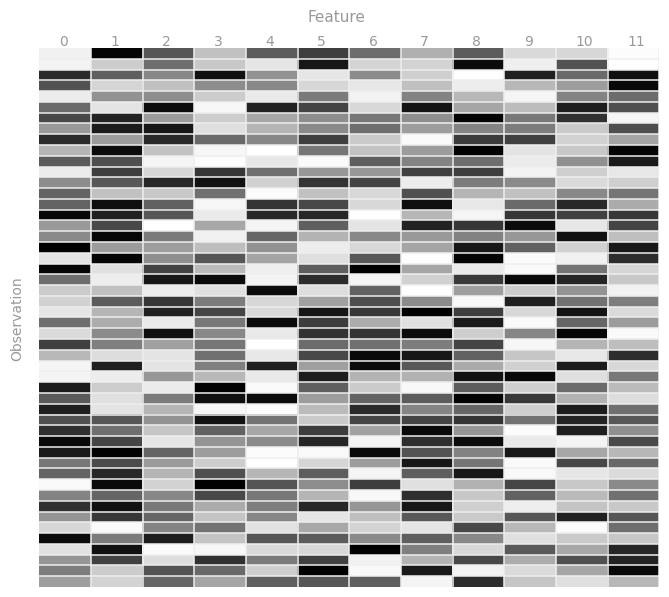

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Simulated data to mimic parsed_points_df features
np.random.seed(47)  # Ensuring reproducibility
data_values = np.random.rand(50, 12)  # 50 samples, 12 features

def prepare_plot(xticks, yticks, figsize=(10.5, 6), hideLabels=False, gridColor='#999999',
                 gridWidth=1.0):
    """Template for generating the plot layout."""
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hideLabels: 
            axis.set_ticklabels([])
    plt.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
    for position in ['bottom', 'top', 'left', 'right']:
        ax.spines[position].set_visible(False)
    return fig, ax

# Generate layout and plot
fig, ax = prepare_plot(np.arange(.5, 12, 1), np.arange(.5, 49, 1), figsize=(8,7), hideLabels=True,
                       gridColor='#eeeeee', gridWidth=1.1)

# Plot heatmap
image = plt.imshow(data_values, interpolation='nearest', aspect='auto', cmap=cm.Greys)

# Add feature labels on x-axis
for x, y, s in zip(np.arange(-.125, 12, 1), np.repeat(-.75, 12), [str(x) for x in range(12)]):
    plt.text(x, y, s, color='#999999', size='10')

# Add axis labels
plt.text(4.7, -3, 'Feature', color='#999999', size='11')
ax.set_ylabel('Observation')

# Display the plot
plt.show()


### (1c) Find the range

Now let's examine the labels to find the range of song years. We will use the min and max functions that are native to the DataFrames, and thus can be optimized using Spark's Catalyst Optimizer and Project Tungsten (don't worry about the technical details). This code will run faster than simply using the native min and max functions in Python. 

 Your task is to find the smallest and largest labels in the `parsed_points_df`. Use [selectExpr](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.selectExpr.html) to retrieve the min and max label values.

In [0]:
from pyspark.sql import SparkSession

# Initialize Spark Session
spark = SparkSession.builder.appName("FindRange").getOrCreate()

# Compute min and max using Spark's optimized selectExpr
content_stats = parsed_points_df.selectExpr("min(label) as min_year", "max(label) as max_year")

# Extract the values
min_year = content_stats.collect()[0]["min_year"]
max_year = content_stats.collect()[0]["max_year"]

# Print results
print("✅ Min Year:", min_year)
print("✅ Max Year:", max_year)

print(parsed_points_df.first())


✅ Min Year: 1922.0
✅ Max Year: 2011.0
Row(features=DenseVector([0.8841, 0.6105, 0.6005, 0.4747, 0.2472, 0.3573, 0.3441, 0.3396, 0.6009, 0.4257, 0.6049, 0.4192]), label=2001.0)


In [0]:
# TEST Find the range (1c)
assert_equal(len(parsed_points_df.first().features), 12,
                  'unexpected number of features in sample point')
sum_feat_two = parsed_points_df.rdd.map(lambda lp: lp.features[2]).sum()
assert_true(np.allclose(sum_feat_two, 3158.96224351), 'parsedPointsDF has unexpected values')
year_range = max_year - min_year
assert_true(year_range == 89, 'incorrect range for minYear to maxYear')

### (1d) Shift labels

As we just saw, the labels are years in the 1900s and 2000s.  In learning problems, it is often natural to shift labels such that they start from zero.  

Starting with `parsed_points_df`, create a new DataFrame in which the labels are shifted such that smallest label equals zero. Then rename the appropriate columns to `features` and `label`.

In [0]:
# Compute the minimum label value (smallest year)
min_label = parsed_points_df.agg({"label": "min"}).collect()[0][0]

# Shift labels so the smallest year becomes 0
parsed_data_df = parsed_points_df.withColumn("label", col("label") - min_label)

# Print the first transformed data point
print("\nFirst transformed data point:")
print(parsed_data_df.first())



First transformed data point:
Row(features=DenseVector([0.8841, 0.6105, 0.6005, 0.4747, 0.2472, 0.3573, 0.3441, 0.3396, 0.6009, 0.4257, 0.6049, 0.4192]), label=79.0)


In [0]:
# TEST Shift labels (1d)
check_column_order = parsed_data_df.columns == ['features', 'label']
assert_true(np.allclose(check_column_order, True), 'expected column order should be [features, label]')
old_sample_features = parsed_points_df.first().features
new_sample_features = parsed_data_df.first().features
assert_true(np.allclose(old_sample_features, new_sample_features),
                'new features do not match old features')
sum_feat_two = parsed_data_df.rdd.map(lambda lp: lp.features[2]).sum()
assert_true(np.allclose(sum_feat_two, 3158.96224351), 'parsed_data_df has unexpected values')
min_year_new = parsed_data_df.groupBy().min('label').first()[0]
max_year_new = parsed_data_df.groupBy().max('label').first()[0]
assert_true(min_year_new == 0, 'incorrect min year in shifted data')
assert_true(max_year_new == 89, 'incorrect max year in shifted data')

### Visualization 2: Shifting labels

We will look at the labels before and after shifting them.  Both scatter plots below visualize tuples storing:

* a label value and
* the number of training points with this label.

The first scatter plot uses the initial labels, while the second one uses the shifted labels.  Note that the two plots look the same except for the labels on the x-axis.

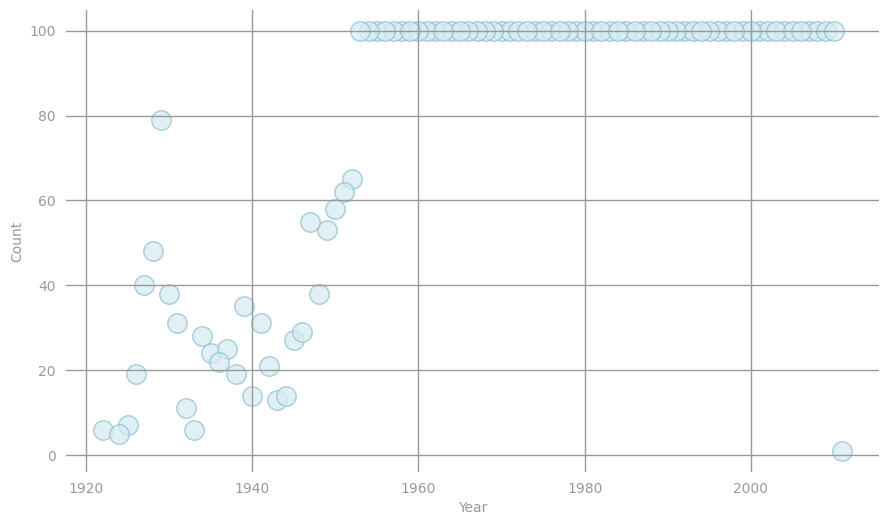

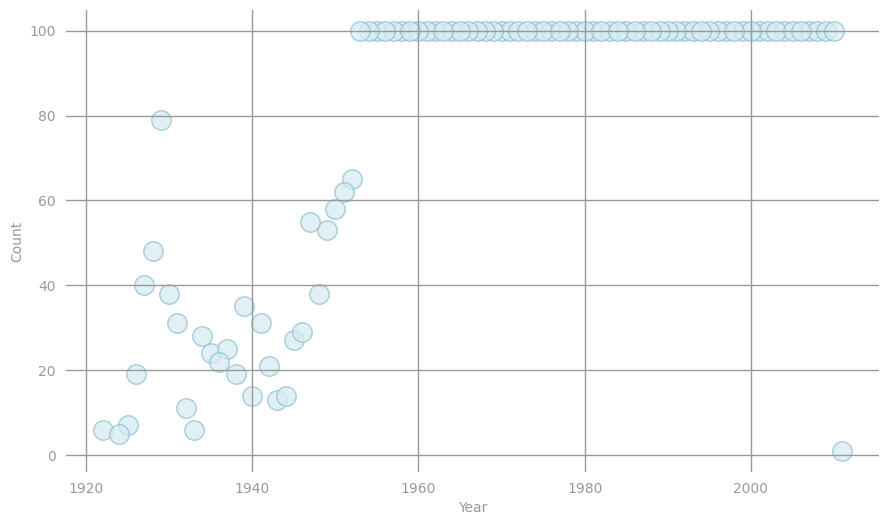

In [0]:
# get data for plot for old data
old_data = (parsed_points_df
             .rdd
             .map(lambda lp: (lp.label, 1))
             .reduceByKey(lambda x, y: x + y)
             .collect())
x, y = zip(*old_data)

# generate layout and plot data
fig, ax = prepare_plot(np.arange(1920, 2050, 20), np.arange(0, 150, 20))
plt.scatter(x, y, s=14**2, c='#d6ebf2', edgecolors='#8cbfd0', alpha=0.75)
ax.set_xlabel('Year'), ax.set_ylabel('Count')
display(fig)

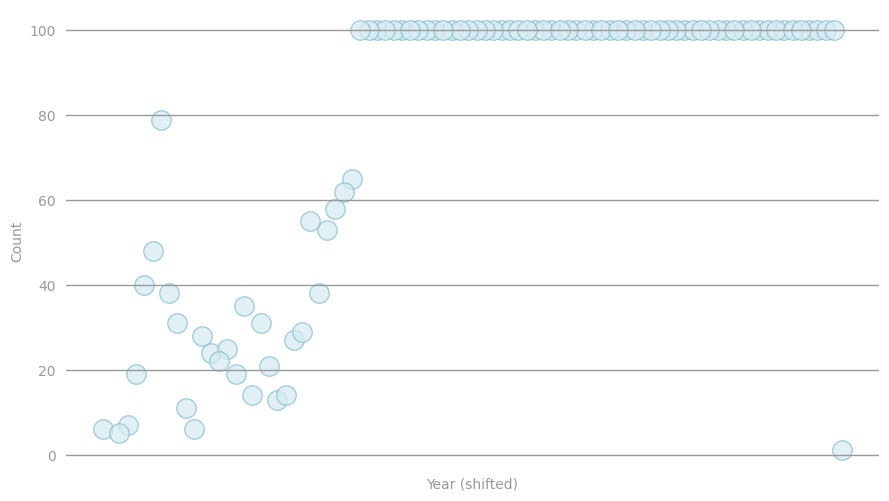

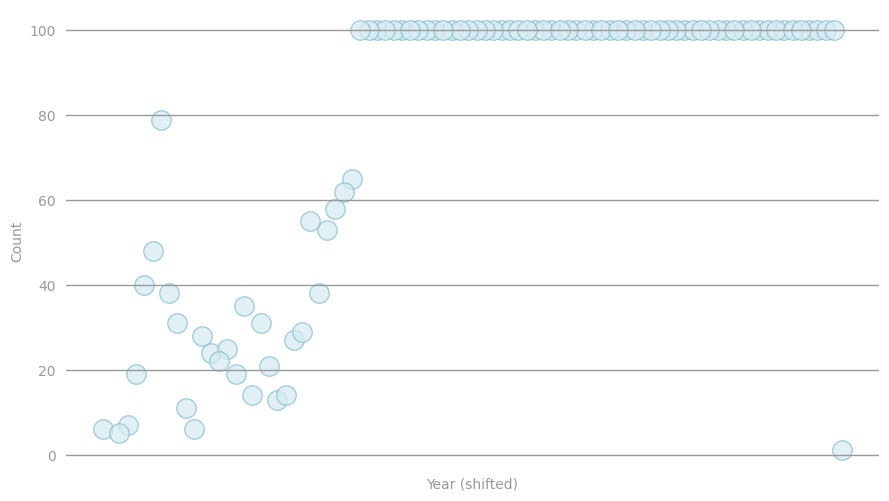

In [0]:
# get data for plot for new data
new_data = (parsed_points_df
             .rdd
             .map(lambda lp: (lp.label, 1))
             .reduceByKey(lambda x, y: x + y)
             .collect())
x, y = zip(*new_data)

# generate layout and plot data
fig, ax = prepare_plot(np.arange(0, 120, 20), np.arange(0, 120, 20))
plt.scatter(x, y, s=14**2, c='#d6ebf2', edgecolors='#8cbfd0', alpha=0.75)
ax.set_xlabel('Year (shifted)'), ax.set_ylabel('Count')
display(fig)
pass

### (1e) Training, validation, and test sets

We're almost done parsing our dataset. 
1. Your final task involves spliting the dataset into training, validation and test sets. Use the [randomSplit method](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.randomSplit.html) with the specified weights and seed to create DataFrames storing each of these datasets. 
2. Cache each of these DataFrames, as you will be accessing them multiple times in the remainder of this lab. 
3. Finally, compute the size of each dataset and verify that the sum of their sizes equals the value computed in Part (1a).

In [0]:
# Define split weights and seed for reproducibility
weights = [0.8, 0.1, 0.1]
seed = 42
# Split dataset into training, validation, and test sets
parsed_train_data_df, parsed_val_data_df, parsed_test_data_df = parsed_data_df.randomSplit(weights, seed)
# Cache the datasets for efficient repeated access
parsed_train_data_df.cache()
parsed_val_data_df.cache()
parsed_test_data_df.cache()
# Compute dataset sizes
n_train = parsed_train_data_df.count()
n_val = parsed_val_data_df.count()
n_test = parsed_test_data_df.count()
# Print dataset sizes and validation
print(n_train, n_val, n_test, n_train + n_val + n_test)
print(parsed_data_df.count())
# Ensure total split size matches original dataset size
assert (n_train + n_val + n_test) == parsed_data_df.count(), "Error: Split sizes do not match original dataset size!"
print("✅ Data successfully split and verified!")

5437 612 675 6724
6724
✅ Data successfully split and verified!


In [0]:
# TEST Training, validation, and test sets (1e)
assert_equal(len(parsed_train_data_df.first().features), 12,
                  'parsed_train_data_df has wrong number of features')
sum_feat_two = (parsed_train_data_df
                 .rdd
                 .map(lambda lp: lp.features[2])
                 .sum())
sum_feat_three = (parsed_val_data_df
                  .rdd
                  .map(lambda lp: lp.features[3])
                  .reduce(lambda x, y: x + y))
sum_feat_four = (parsed_test_data_df
                  .rdd
                  .map(lambda lp: lp.features[4])
                  .reduce(lambda x, y: x + y))
assert_true(np.allclose([sum_feat_two, sum_feat_three, sum_feat_four],
                            [2556.1542344080995, 266.2183689066131, 183.91965637035335]),
                'parsed Train, Val, Test data has unexpected values')
assert_true(n_train + n_val + n_test == 6724, 'unexpected Train, Val, Test data set size')
assert_equal(n_train, 5437, 'unexpected value for nTrain')
assert_equal(n_val, 612, 'unexpected value for nVal')
assert_equal(n_test, 675, 'unexpected value for nTest')

## Part 2: Create and evaluate a baseline model

### (2a) Average label

A very simple yet natural baseline model is one where we always make the same prediction independent of the given data point, using the average label in the training set as the constant prediction value.  Your task is to compute this value, which is the average (shifted) song year for the training set.  Use `selectExpr` and `first()` from the [DataFrame API](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.html) to complete your task.

In [0]:
# TODO: Uncomment the following lines and replace <FILL IN> with appropriate code
# average_train_year = (parsed_train_data_df
#                         .<FILL IN>)

# YOUR CODE HERE

# Compute the average label (shifted song year) in the training set
average_train_year = parsed_train_data_df.selectExpr("avg(label) as avg_train_year").first()["avg_train_year"]

# Print the computed average train year
print(average_train_year)

#raise NotImplementedError()

#print (average_train_year)

53.59518116608424


In [0]:
# TEST Average label (2a)
assert_true(np.allclose(average_train_year, 53.59518116608424),
                'incorrect value for average_train_year')

### (2b) Root mean squared error

We naturally would like to see how well this naive baseline performs.  We will use root mean squared error ([RMSE](http://en.wikipedia.org/wiki/Root-mean-square_deviation)) for evaluation purposes.  Using [Regression Evaluator](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.evaluation.RegressionEvaluator.html), your task is to compute the RMSE given a dataset of _(prediction, label)_ tuples.

In [0]:
from pyspark.ml.evaluation import RegressionEvaluator


preds_and_labels = [(1., 3.), (2., 1.), (2., 2.)]
preds_and_labels_df = spark.createDataFrame(preds_and_labels, ["prediction", "label"])

def calc_RMSE(dataset):
    """Calculates the root mean squared error (RMSE) for a dataset of (prediction, label) tuples.

    Args:
        dataset (DataFrame of (float, float)): A `DataFrame` consisting of (prediction, label) tuples.

    Returns:
        float: The square root of the mean of the squared errors (RMSE).
    """
    evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
    return evaluator.evaluate(dataset)

example_rmse = calc_RMSE(preds_and_labels_df)
print("✅ Computed RMSE:", example_rmse)

✅ Computed RMSE: 1.2909944487358058


In [0]:
# TEST Root mean squared error (2b)
example_rmse = calc_RMSE(preds_and_labels_df)
assert_true(np.allclose(example_rmse, 1.2909944487358058), 'incorrect value for RMSE')

### (2c) Training, validation and test RMSE

Now let's calculate the training, validation and test RMSE of our baseline model. To do this, you should create DataFrames of _(prediction, label)_ tuples for each dataset, and then call `calc_RMSE()`. 

Note that each RMSE can be interpreted as the average prediction error for the given dataset (in terms of number of years). You can use [createDataFrame](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.SparkSession.createDataFrame.html) to create a DataFrame with the column names "prediction" and "label" from an RDD.

In [0]:
# Compute baseline predictions for training, validation, and test sets
preds_and_labels_train = parsed_train_data_df.rdd.map(lambda row: (average_train_year, row.label))
preds_and_labels_val = parsed_val_data_df.rdd.map(lambda row: (average_train_year, row.label))
preds_and_labels_test = parsed_test_data_df.rdd.map(lambda row: (average_train_year, row.label))

# Convert RDDs to DataFrames
preds_and_labels_train_df = spark.createDataFrame(preds_and_labels_train, ["prediction", "label"])
preds_and_labels_val_df = spark.createDataFrame(preds_and_labels_val, ["prediction", "label"])
preds_and_labels_test_df = spark.createDataFrame(preds_and_labels_test, ["prediction", "label"])

# Compute RMSE for each dataset
rmse_train_base = calc_RMSE(preds_and_labels_train_df)
rmse_val_base = calc_RMSE(preds_and_labels_val_df)
rmse_test_base = calc_RMSE(preds_and_labels_test_df)

# Print results
print('Baseline Train RMSE = {0:.3f}'.format(rmse_train_base))
print('Baseline Validation RMSE = {0:.3f}'.format(rmse_val_base))
print('Baseline Test RMSE = {0:.3f}'.format(rmse_test_base))

Baseline Train RMSE = 21.466
Baseline Validation RMSE = 21.159
Baseline Test RMSE = 21.271


In [0]:
# TEST Training, validation and test RMSE (2c)
assert_true(np.allclose([rmse_train_base, rmse_val_base, rmse_test_base],
                            [21.466417064061876, 21.159492901731717, 21.27108361796124]), 'incorrect RMSE values')

### Visualization 3: Predicted vs. actual

We will visualize predictions on the validation dataset. The scatter plots below visualize tuples storing i) the predicted value and ii) true label.  The first scatter plot represents the ideal situation where the predicted value exactly equals the true label, while the second plot uses the baseline predictor (i.e., `average_train_year`) for all predicted values.  Further note that the points in the scatter plots are color-coded, ranging from light yellow when the true and predicted values are equal to bright red when they drastically differ.

/root/.ipykernel/985/command-1395764874084249-4121758241:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('YlOrRd')


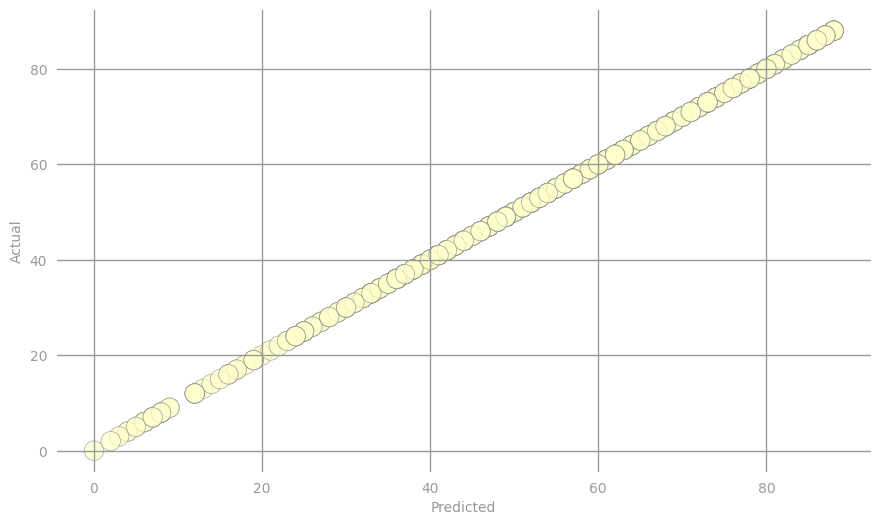

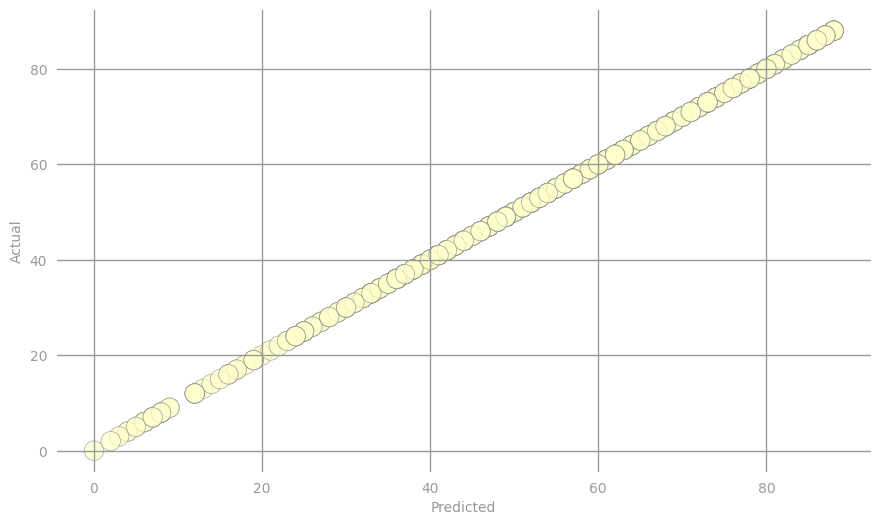

In [0]:
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import get_cmap
cmap = get_cmap('YlOrRd')
norm = Normalize()

def squared_error(lp):
    """Calculates the squared error for a single prediction."""
    label, prediction = lp
    return float((label - prediction)**2)

actual = np.asarray(parsed_val_data_df
                    .select('label')
                    .collect())
error = np.asarray(parsed_val_data_df
                   .rdd
                   .map(lambda lp: (lp.label, lp.label))
                   .map(lambda lp: squared_error(lp))
                   .collect())
clrs = cmap(np.asarray(norm(error)))[:,0:3]

fig, ax = prepare_plot(np.arange(0, 100, 20), np.arange(0, 100, 20))
plt.scatter(actual, actual, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=0.5)
ax.set_xlabel('Predicted'), ax.set_ylabel('Actual')
display(fig)

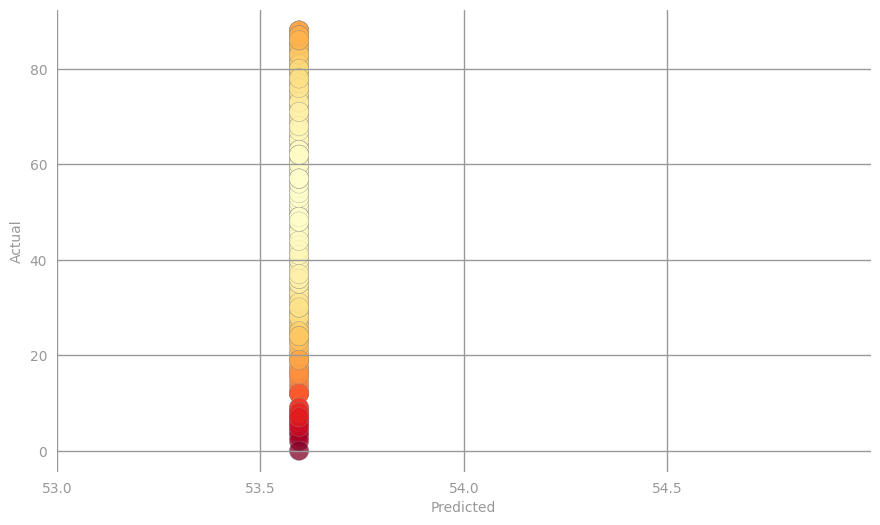

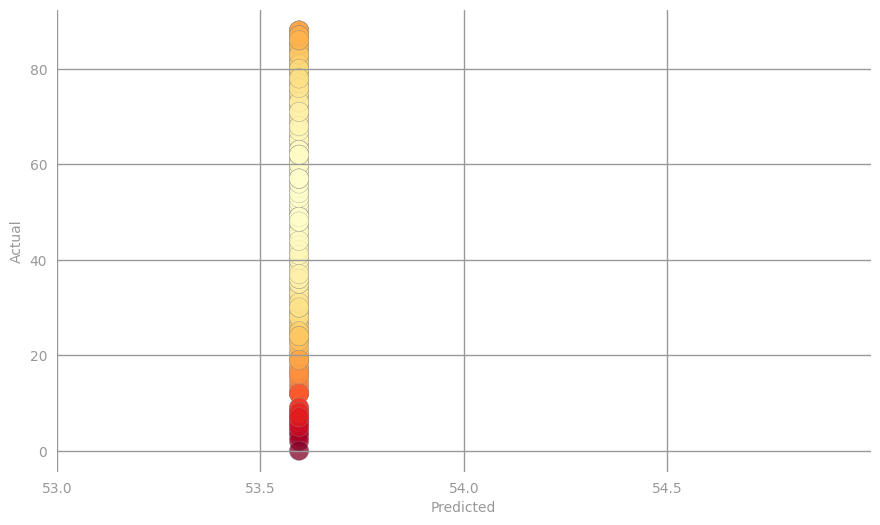

In [0]:
def squared_error(lp):
    """Calculates the squared error for a single prediction."""
    label, prediction = lp
    return float((label - prediction)**2)

predictions = np.asarray(parsed_val_data_df
                         .rdd
                         .map(lambda lp: average_train_year)
                         .collect())
error = np.asarray(parsed_val_data_df
                   .rdd
                   .map(lambda lp: (lp.label, average_train_year))
                   .map(lambda lp: squared_error(lp))
                   .collect())
norm = Normalize()
clrs = cmap(np.asarray(norm(error)))[:,0:3]

fig, ax = prepare_plot(np.arange(53.0, 55.0, 0.5), np.arange(0, 100, 20))
ax.set_xlim(53, 55)
plt.scatter(predictions, actual, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=0.3)
ax.set_xlabel('Predicted'), ax.set_ylabel('Actual')
display(fig)

## Part 3: Train (via gradient descent) and evaluate a linear regression model

### (3a) Gradient summand

Now let's see if we can do better via linear regression, training a model via gradient descent (we'll omit the intercept for now). Recall that the gradient descent update for linear regression is:
\\[ \scriptsize \mathbf{w}_{i+1} = \mathbf{w}_i - \alpha_i \sum_j (\mathbf{w}_i^\top\mathbf{x}_j  - y_j) \mathbf{x}_j \,.\\]
where \\( \scriptsize i \\) is the iteration number of the gradient descent algorithm, \\( \scriptsize j \\) identifies the observation, \\( \scriptsize \alpha \\) is the learning rate

First, implement a function that computes the summand for this update, i.e., the summand equals \\( \scriptsize (\mathbf{w}^\top \mathbf{x} - y) \mathbf{x} \, ,\\) and test out this function on two examples.  Use the `DenseVector` [dot](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.linalg.DenseVector.html#pyspark.ml.linalg.DenseVector.dot) method.

In [0]:
from pyspark.mllib.linalg import DenseVector

In [0]:
#from pyspark.ml.linalg import DenseVector
from pyspark.mllib.regression import LabeledPoint

def gradient_summand(weights, lp):
    """Calculates the gradient summand for a given weight vector and `LabeledPoint`.

    Args:
        weights (DenseVector): An array of model weights (betas).
        lp (LabeledPoint): The `LabeledPoint` for a single observation.

    Returns:
        DenseVector: An array of values the same length as `weights`. The gradient summand.
    """
    # Compute prediction: w^T * x
    prediction = weights.dot(lp.features)

    # Compute error: (w^T * x - y)
    error = prediction - lp.label

    # Compute gradient summand: (error) * x
    return DenseVector(error * lp.features)

# Test cases
example_w1 = DenseVector([1, 1, 1])
example_lp1 = LabeledPoint(2.0, DenseVector([3, 1, 4]))
summand_one = gradient_summand(example_w1, example_lp1)
print("Gradient Summand 1:", summand_one)

example_w2 = DenseVector([0.24, 1.2, -1.4])
example_lp2 = LabeledPoint(3.0, DenseVector([-1.4, 4.2, 2.1]))
summand_two = gradient_summand(example_w2, example_lp2)
print("Gradient Summand 2:", summand_two)


Gradient Summand 1: [18.0,6.0,24.0]
Gradient Summand 2: [1.7304000000000002,-5.191200000000001,-2.5956000000000006]


In [0]:
# TEST Gradient summand (3a)
example_w = DenseVector([1, 1, 1])
example_lp = LabeledPoint(2.0, [3, 1, 4])
summand_one = gradient_summand(example_w, example_lp)

assert_true(np.allclose(summand_one, [18., 6., 24.]), 'incorrect value for summand_one')

### (3b) Use weights to make predictions

Next, implement a `get_labeled_predictions` function that takes in weights and an observation's `LabeledPoint` and returns a _(prediction, label)_ tuple.  Note that we can predict by computing the dot product between weights and an observation's features.

In [0]:
import numpy as np
from pyspark.mllib.regression import LabeledPoint

def prediction_example():
    """Creates a sample set of LabeledPoints for testing predictions."""
    return [
        LabeledPoint(2, np.array([1.0, 0.5])),
        LabeledPoint(1.5, np.array([0.5, 0.5]))
    ]

# ✅ Test case validation
weights = np.array([1.0, 1.5])
example_data = prediction_example()

def get_labeled_prediction(weights, observation):
    """Calculates predictions and returns a (prediction, label) tuple."""
    prediction = float(np.dot(weights, observation.features))
    return prediction, float(observation.label)

preds_and_labels_example = [get_labeled_prediction(weights, lp) for lp in example_data]

assert preds_and_labels_example == [(1.75, 2.0), (1.25, 1.5)], "Incorrect predictions"

print("✅ prediction_example function recreated successfully!")

✅ prediction_example function recreated successfully!


In [0]:
# TEST Use weights to make predictions (3b)

example_data = prediction_example()  # Call the function to get the data
example_rdd = sc.parallelize(example_data)  # Convert to RDD
preds_and_labels_example = example_rdd.map(lambda lp: get_labeled_prediction(weights, lp))

#preds_and_labels_example = prediction_example.map(lambda lp: get_labeled_prediction(weights, lp))

assert_true(isinstance(preds_and_labels_example.first()[0], float), 'prediction must be a float')
assert_equal(preds_and_labels_example.collect(), [(1.75, 2.0), (1.25, 1.5)],
                  'incorrect definition for getLabeledPredictions')

### (3c) Gradient descent

Next, implement a gradient descent function for linear regression and test out this function on an example.

In [0]:
import numpy as np
from pyspark.mllib.linalg import DenseVector

def linreg_gradient_descent(train_data, num_iters):
    """Performs gradient descent for linear regression.

    Args:
        train_data (RDD of LabeledPoint): Training dataset.
        num_iters (int): Number of iterations.

    Returns:
        tuple: (final weights, training error per iteration).
    """
    # Ensure train_data is an RDD
    if not isinstance(train_data, pyspark.RDD):
        train_data = train_data.rdd  # Convert DataFrame to RDD

    # Number of training samples
    n = train_data.count()

    # Number of features
    d = len(train_data.first().features)

    # Initialize weights to zero
    w = np.zeros(d)

    # Learning rate
    alpha = 1.0

    # Store training error per iteration
    error_train = np.zeros(num_iters)

    for i in range(num_iters):
        # Compute predictions
        preds_and_labels_train = train_data.map(lambda lp: get_labeled_prediction(w, lp))
        preds_and_labels_train_df = spark.createDataFrame(preds_and_labels_train, ["prediction", "label"])

        # Compute RMSE for the current iteration
        error_train[i] = calc_RMSE(preds_and_labels_train_df)

        # Compute gradient using all data points
        gradient = train_data.map(lambda lp: gradient_summand(w, lp)).reduce(lambda a, b: a + b)

        # Decay the learning rate
        alpha_i = alpha / (n * np.sqrt(i + 1))

        # Update weights
        w -= alpha_i * gradient

    return w, error_train


In [0]:
# Define example dataset
example_n = 10  # Number of data points
example_d = 3   # Number of features

# Extract a subset from training data and convert to RDD
example_data = (sc.parallelize(parsed_train_data_df.take(example_n))
                  .map(lambda lp: LabeledPoint(lp.label, lp.features[0:example_d])))

# Run gradient descent
example_num_iters = 5
example_weights, example_error_train = linreg_gradient_descent(example_data, example_num_iters)

# ✅ Now the test should work
expected_output = [4.33247264, 33.15818324, 17.87338995]
assert_true(np.allclose(example_weights, expected_output), 'value of example_weights is incorrect')

expected_error = [43.34166587, 36.99254897, 34.47990014, 33.12921281, 32.30150161]
assert_true(np.allclose(example_error_train, expected_error), 'value of exampleErrorTrain is incorrect')

print("✅ Gradient descent test passed!")


✅ Gradient descent test passed!


### (3d) Train the model

Now let's train a linear regression model on all of our training data and evaluate its accuracy on the validation set.  Note that the test set will not be used here.  If we evaluated the model on the test set, we would bias our final results.

We've already done much of the required work: we computed the number of features in Part (1b); we created the training and validation datasets and computed their sizes in Part (1e); and, we wrote a function to compute RMSE in Part (2b).

In [0]:
# Define the number of iterations for gradient descent
num_iters = 30

# Train the linear regression model using gradient descent on the training data
weights_LR, error_train_LR = linreg_gradient_descent(parsed_train_data_df, num_iters)

# Compute predictions on the validation set by applying the learned weights
preds_and_labels = parsed_val_data_df.selectExpr("features", "label") \
    .rdd.map(lambda row: (float(np.dot(weights_LR, row.features)), float(row.label)))

# Convert to DataFrame
preds_and_labels_df = spark.createDataFrame(preds_and_labels, ["prediction", "label"])

# Compute RMSE on the validation set
rmse_val_LR0 = calc_RMSE(preds_and_labels_df)

# Print results
print('Validation RMSE:\n\tBaseline = {0:.3f}\n\tLR0 = {1:.3f}'.format(rmse_val_base, rmse_val_LR0))


Validation RMSE:
	Baseline = 21.159
	LR0 = 19.054


In [0]:
# TEST Train the model (3d)
expected_output =[20.38822921, 18.37081975,  1.65771419,  8.07448229, 5.55803544, -1.81674641,
 13.80673629,  4.92861749, 10.06643157,  6.57597723, 10.58621883, 4.92736118]
assert_true(np.allclose(weights_LR, expected_output), 'incorrect value for weights_LR')


### Visualization 4: Training error

We will look at the log of the training error as a function of iteration. The first scatter plot visualizes the logarithm of the training error for all 50 iterations.  The second plot shows the training error itself, focusing on the final 44 iterations.

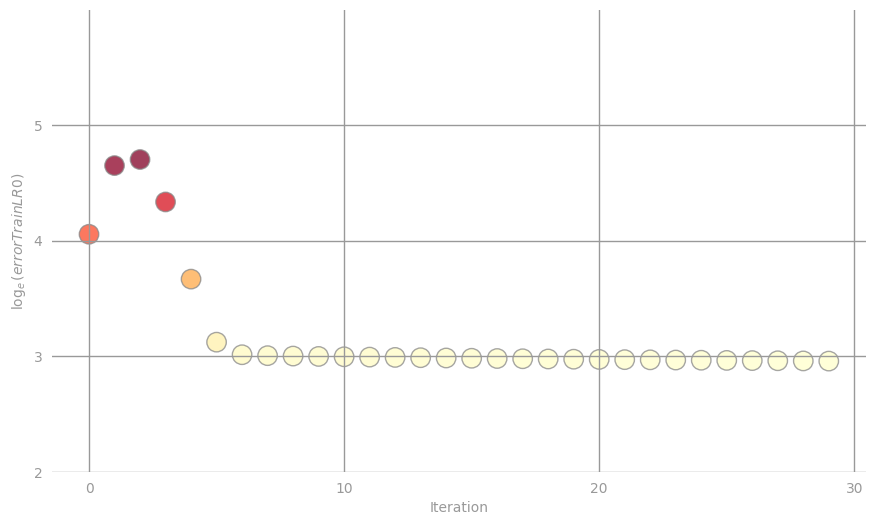

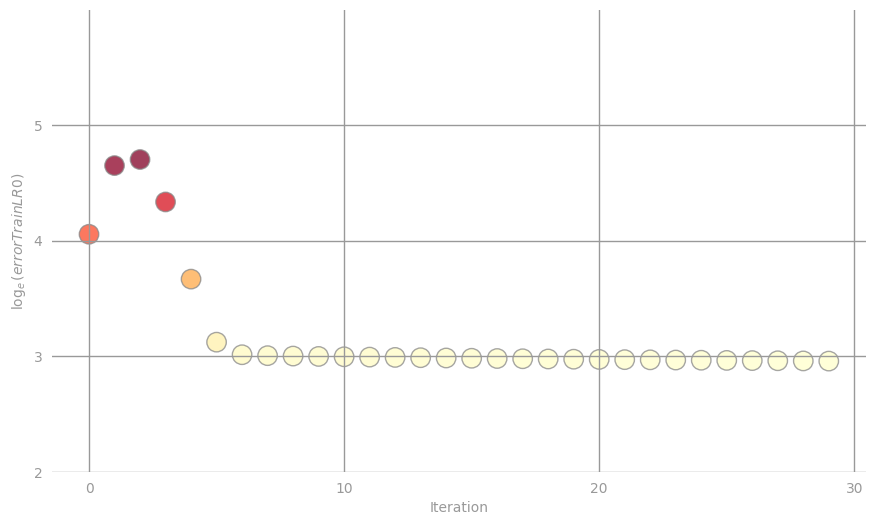

In [0]:
norm = Normalize()
clrs = cmap(np.asarray(norm(np.log(error_train_LR))))[:,0:3]

fig, ax = prepare_plot(np.arange(0, 60, 10), np.arange(2, 6, 1))
ax.set_ylim(2, 6)
plt.scatter(range(0, num_iters), np.log(error_train_LR), s=14**2, c=clrs, edgecolors='#888888', alpha=0.75)
ax.set_xlabel('Iteration'), ax.set_ylabel(r'$\log_e(errorTrainLR0)$')
display(fig)

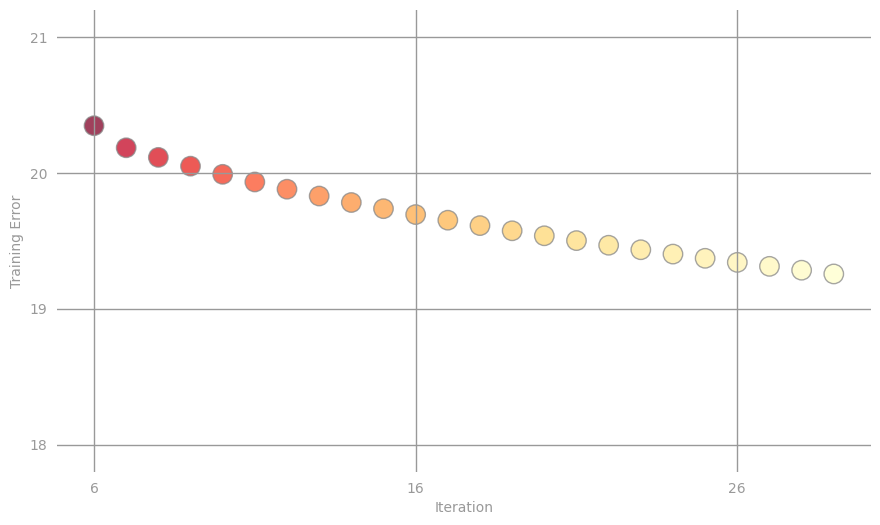

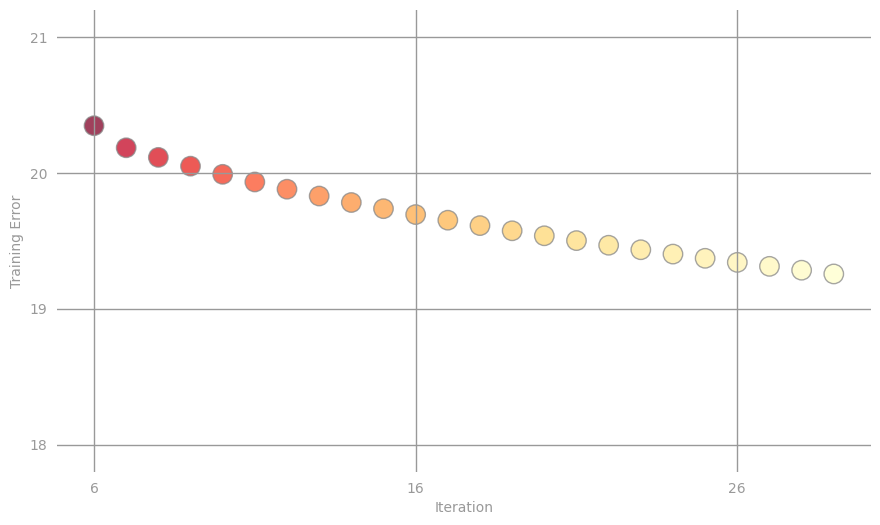

In [0]:
norm = Normalize()
clrs = cmap(np.asarray(norm(error_train_LR[6:])))[:,0:3]

fig, ax = prepare_plot(np.arange(0, 60, 10), np.arange(17, 22, 1))
ax.set_ylim(17.8, 21.2)
plt.scatter(range(0, num_iters-6), error_train_LR[6:], s=14**2, c=clrs, edgecolors='#888888', alpha=0.75)
ax.set_xticklabels(map(str, range(6, 66, 10)))
ax.set_xlabel('Iteration'), ax.set_ylabel(r'Training Error')
display(fig)

## Part 4: Train using SparkML and perform grid search

### (4a) `LinearRegression`
We're already doing better than the baseline model, but let's see if we can do better by adding an intercept, using regularization, and (based on the previous visualization) training for more iterations. MLlib's [LinearRegressionWithSGD](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.mllib.regression.LinearRegressionWithSGD.html) essentially applys same idea that we used in Part (3b), albeit using stochastic gradient approximation and more efficiently with various additional functionality including an intercept in the model and also allowing L1 or L2 regularization.

First use [LinearRegressionWithSGD](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.mllib.regression.LinearRegressionWithSGD.html) to train a model with L2 regularization and with an intercept. This method returns a LinearRegressionModel. Next, use the model's weights (ex model.weights) and intercept (ex model.intercept) attributes to print out the model's parameters

In [0]:
from pyspark.mllib.regression import LinearRegressionWithSGD
# Values to use when training the linear regression model
numIters = 500  # iterations
alpha = 1.0  # step
miniBatchFrac = 1.0  # miniBatchFraction
reg = 1e-1  # regParam
regType = 'l2'  # regType
useIntercept = True  # intercept

In [0]:
from pyspark.mllib.regression import LinearRegressionWithSGD

# Values to use when training the linear regression model
numIters = 500  # iterations
alpha = 1.0  # step size
miniBatchFrac = 1.0  # miniBatchFraction
reg = 1e-1  # regParam (L2 regularization strength)
regType = 'l2'  # Regularization type
useIntercept = True  # Whether to use an intercept

# Ensure training data is in the required format (RDD of LabeledPoint)
train_rdd = parsed_train_data_df.rdd.map(lambda row: LabeledPoint(row.label, row.features))

# Train the Linear Regression model using SGD
first_model = LinearRegressionWithSGD.train(
    data=train_rdd,
    iterations=numIters,
    step=alpha,
    miniBatchFraction=miniBatchFrac,
    initialWeights=None,  # Let the model initialize weights
    regParam=reg,
    regType=regType,
    intercept=useIntercept
)

# Extract coefficients and intercept from the trained model
coeffs_LR1 = first_model.weights
intercept_LR1 = first_model.intercept

# Print results
print("Model Coefficients:", coeffs_LR1)
print("Model Intercept:", intercept_LR1)


/databricks/spark/python/pyspark/mllib/regression.py:365: FutureWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.", FutureWarning)


Model Coefficients: [15.803493878440255,14.257597193648545,0.5687980903797989,5.9986578719505985,3.8848794976051675,-2.267933679064578,10.470642172856698,3.0897973928916045,7.209823036574606,4.584259775363968,7.670266229374437,3.149991806531072]
Model Intercept: 13.352400911870854


In [0]:
# TEST LinearRegression (4a)
expected_intercept = 13.35240091187086
expected_weights= [15.803493878440253,14.257597193648554,0.5687980903798003,5.998657871950593,3.8848794976051675,-2.267933679064589,10.47064217285669,3.089797392891599,7.2098230365746,4.584259775363974,7.670266229374442,3.149991806531069]
assert_true(np.allclose(intercept_LR1, expected_intercept), 'incorrect value for intercept_LR1')
assert_true(np.allclose(coeffs_LR1, expected_weights), 'incorrect value for coeffs_LR1')

### (4b) Predict

Now use the [LinearRegressionModel.predict()](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.mllib.regression.LinearRegressionModel.html#pyspark.mllib.regression.LinearRegressionModel.predict) method to make a prediction on a sample point. Pass the features from a LabeledPoint into the predict() method

In [0]:
# Extract a sample data point from the training set
samplePoint = parsed_train_data_df.rdd.take(1)[0]  # Ensure it's taken as an RDD entry

# Make a prediction using the trained Linear Regression model
sample_prediction = first_model.predict(samplePoint.features)

# Print the predicted value
print("Sample Prediction:", sample_prediction)


Sample Prediction: 39.876457310687975


In [0]:
# TEST Predict (4b)
assert_true(np.allclose(sample_prediction, 39.87645731068798),
                'incorrect value for sample_prediction')

### (4c) Evaluate RMSE

Next evaluate the accuracy of this model on the validation set.  First, map [LinearRegressionModel.predict()](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.mllib.regression.LinearRegressionModel.html#pyspark.mllib.regression.LinearRegressionModel.predict) method on features in parsed_val_data_df to get labelsAndPreds. Create a dataframe based on that and then use the `calc_RMSE()` function from Part (2b).

In [0]:
# Ensure parsed_val_data_df exists
if 'parsed_val_data_df' not in locals():
    raise NameError("Error: parsed_val_data_df is not defined. Re-run the cell that creates it.")

# Compute predictions and labels using the trained model
labels_and_preds = parsed_val_data_df.rdd.map(lambda lp: (lp.label, float(first_model.predict(lp.features))))

# Convert to a DataFrame
labels_and_preds_df = spark.createDataFrame(labels_and_preds, ["label", "prediction"])

# Compute RMSE
rmse_val_LR1 = calc_RMSE(labels_and_preds_df)

# Print RMSE
print("Validation RMSE for Linear Regression Model with Intercept:", rmse_val_LR1)


Validation RMSE for Linear Regression Model with Intercept: 19.30422113647903


In [0]:
# TEST Evaluate RMSE (4c)
assert_true(np.allclose(rmse_val_LR1, 19.304221136479025), 'incorrect value for rmseValLR1')

### (4d) Grid search

We're already outperforming the baseline on the validation set by almost 2 years on average, but let's see if we can do better. Perform grid search to find a good regularization parameter.  Try `regParam` values `1e-10`, `1e-5`, and `1.0`.

In [0]:
# Define grid search parameters
reg_params = [1e-10, 1e-5, 1.0]

# Initialize best model tracking variables
best_RMSE = rmse_val_LR1
best_reg_param = reg
best_model = first_model

# Model training settings
regType = 'l2'  # Regularization type
useIntercept = True  # Whether to use intercept
num_iters = 500  # Number of iterations
alpha = 1.0  # Learning rate
miniBatchFrac = 1.0  # Mini-batch fraction

# Convert validation data to RDD format if needed
parsed_val_data_rdd = parsed_val_data_df.rdd.map(lambda row: LabeledPoint(row.label, row.features))

# Perform grid search over different regularization parameters
for reg in reg_params:
    # Train the model with current regularization parameter
    model = LinearRegressionWithSGD.train(
        data=parsed_train_data_df.rdd.map(lambda row: LabeledPoint(row.label, row.features)),
        iterations=num_iters,
        step=alpha,
        miniBatchFraction=miniBatchFrac,
        initialWeights=None,  # Let Spark initialize weights
        regParam=reg,
        regType=regType,
        intercept=useIntercept
    )

    # Compute predictions and labels using the trained model
    labels_and_preds = parsed_val_data_rdd.map(lambda lp: (lp.label, float(model.predict(lp.features))))

    # Convert to a DataFrame
    labels_and_preds_df = spark.createDataFrame(labels_and_preds, ["label", "prediction"])

    # Compute RMSE
    rmse_val_grid = calc_RMSE(labels_and_preds_df)
    print(f"RMSE for regParam={reg}: {rmse_val_grid:.3f}")

    # Update best model if current one performs better
    if rmse_val_grid < best_RMSE:
        best_RMSE = rmse_val_grid
        best_reg_param = reg
        best_model = model

# Final best RMSE from grid search
rmse_val_LR_grid = best_RMSE

# Print final results
print(('Validation RMSE:\n\tBaseline = {0:.3f}\n\tLR0 = {1:.3f}\n\tLR1 = {2:.3f}\n' +
       '\tLRGrid = {3:.3f}').format(rmse_val_base, rmse_val_LR0, rmse_val_LR1, rmse_val_LR_grid))


RMSE for regParam=1e-10: 16.987
RMSE for regParam=1e-05: 16.987
RMSE for regParam=1.0: 23.058
Validation RMSE:
	Baseline = 21.159
	LR0 = 19.054
	LR1 = 19.304
	LRGrid = 16.987


In [0]:
# TEST Grid search (4d)
assert_true(np.allclose(16.98706511744755, rmse_val_LR_grid), 'incorrect value for rmseValLRGrid')

### Visualization 5: Best model's predictions

Next, we create a visualization similar to 'Visualization 3: Predicted vs. actual' from Part 2 using the predictions from the best model from Part (4d) on the validation dataset.  Specifically, we create a color-coded scatter plot visualizing tuples storing i) the predicted value from this model and ii) true label.

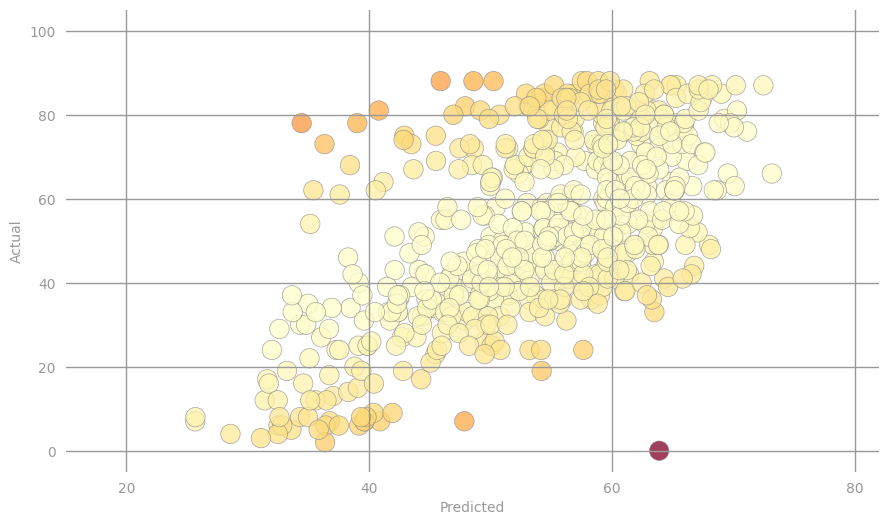

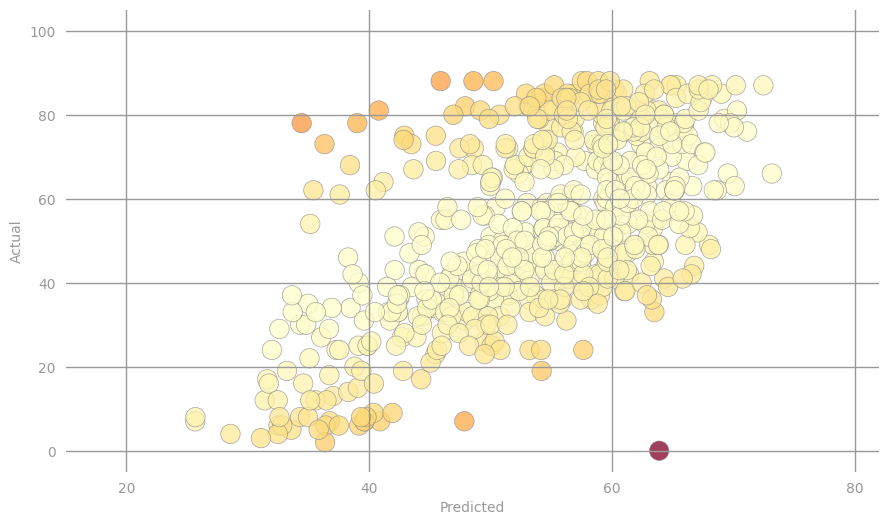

In [0]:
predictions = np.asarray(parsed_val_data_df.rdd
                         .map(lambda lp: best_model.predict(lp.features))
                         .collect())
actual = np.asarray(parsed_val_data_df.rdd
                    .map(lambda lp: lp.label)
                    .collect())
error = np.asarray(parsed_val_data_df.rdd
                   .map(lambda lp: (lp.label, best_model.predict(lp.features)))
                   .map( lambda lp: squared_error(lp))
                   .collect())

norm = Normalize()
clrs = cmap(np.asarray(norm(error)))[:,0:3]

fig, ax = prepare_plot(np.arange(0, 120, 20), np.arange(0, 120, 20))
ax.set_xlim(15, 82), ax.set_ylim(-5, 105)
plt.scatter(predictions, actual, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=.5)
ax.set_xlabel('Predicted'), ax.set_ylabel(r'Actual')
display(fig) 
pass



### Visualization 6: Hyperparameter heat map

Next, we perform a visualization of hyperparameter search using a larger set of hyperparameters (with precomputed results).  Specifically, we create a heat map where the brighter colors correspond to lower RMSE values.  The first plot has a large area with brighter colors.  In order to differentiate within the bright region, we generate a second plot corresponding to the hyperparameters found within that region.

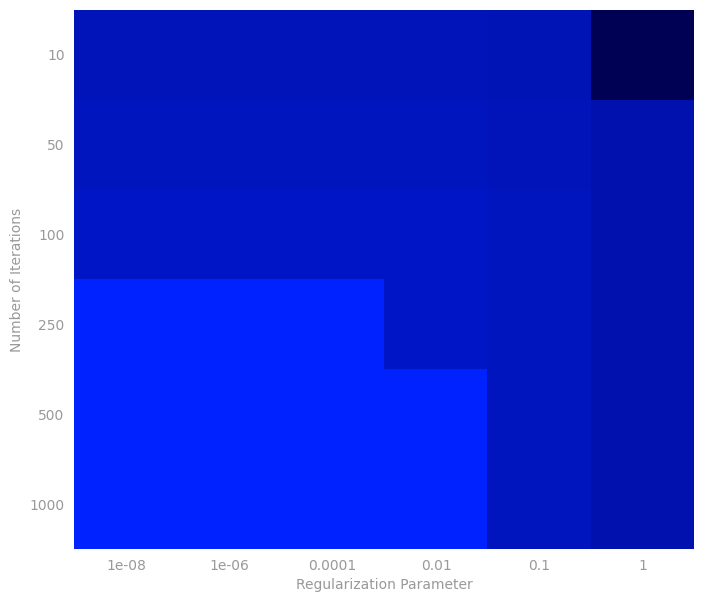

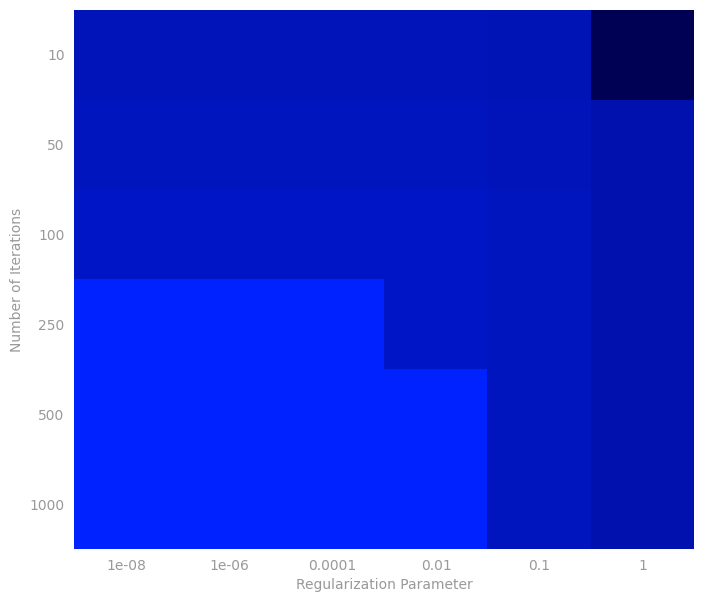

In [0]:
from matplotlib.colors import LinearSegmentedColormap

# Saved parameters and results, to save the time required to run 36 models
numItersParams = [10, 50, 100, 250, 500, 1000]
regParams = [1e-8, 1e-6, 1e-4, 1e-2, 1e-1, 1]
rmseVal = np.array([[  20.36769649,   20.36770128,   20.36818057,   20.41795354,  21.09778437,  301.54258421],
                    [  19.04948826,   19.0495    ,   19.05067418,   19.16517726,  19.97967727,   23.80077467],
                    [  18.40149024,   18.40150998,   18.40348326,   18.59457491,  19.82155716,   23.80077467],
                    [  17.5609346 ,   17.56096749,   17.56425511,   17.88442127,  19.71577117,   23.80077467],
                    [  17.0171705 ,   17.01721288,   17.02145207,   17.44510574,  19.69124734,   23.80077467],
                    [  16.58074813,   16.58079874,   16.58586512,   17.11466904,  19.6860931 ,   23.80077467]])

numRows, numCols = len(numItersParams), len(regParams)
rmseVal = np.array(rmseVal)
rmseVal.shape = (numRows, numCols)

fig, ax = prepare_plot(np.arange(0, numCols, 1), np.arange(0, numRows, 1), figsize=(8, 7), hideLabels=True,
                      gridWidth=0.)
ax.set_xticklabels(regParams), ax.set_yticklabels(numItersParams)
ax.set_xlabel('Regularization Parameter'), ax.set_ylabel('Number of Iterations')

colors = LinearSegmentedColormap.from_list('blue', ['#0022ff', '#000055'], gamma=.2)
image = plt.imshow(rmseVal,interpolation='nearest', aspect='auto',
                    cmap = colors)
display(fig) 

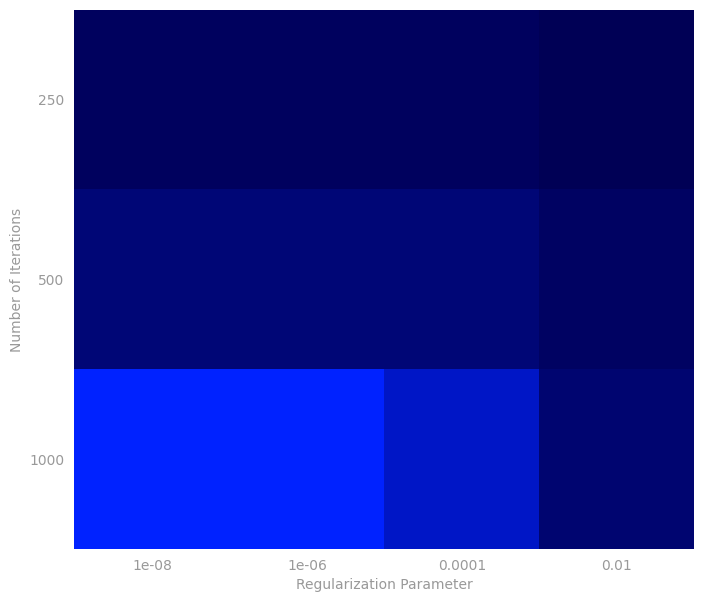

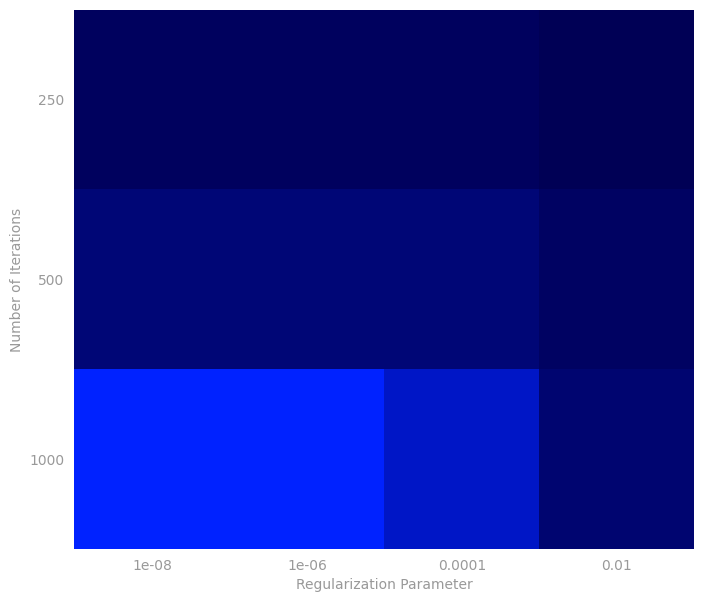

In [0]:
# Zoom into the bottom left
numItersParamsZoom, regParamsZoom = numItersParams[-3:], regParams[:4]
rmseValZoom = rmseVal[-3:, :4]

numRows, numCols = len(numItersParamsZoom), len(regParamsZoom)

fig, ax = prepare_plot(np.arange(0, numCols, 1), np.arange(0, numRows, 1), figsize=(8, 7), hideLabels=True,
                      gridWidth=0.)
ax.set_xticklabels(regParamsZoom), ax.set_yticklabels(numItersParamsZoom)
ax.set_xlabel('Regularization Parameter'), ax.set_ylabel('Number of Iterations')

colors = LinearSegmentedColormap.from_list('blue', ['#0022ff', '#000055'], gamma=.2)
image = plt.imshow(rmseValZoom,interpolation='nearest', aspect='auto',
                    cmap = colors)
display(fig) 
pass

## Part 5: Add interactions between features

### (5a) Add 2-way interactions

So far, we've used the features as they were provided.  Now, we will add features that capture the two-way interactions between our existing features.  Write a function `two_way_interactions` that takes in a `LabeledPoint` and generates a new `LabeledPoint` that contains the old features and the two-way interactions between them.

> Note:
> * A dataset with three features would have nine ( \\( \scriptsize 3^2 \\) ) two-way interactions.
> * You might want to use [itertools.product](https://docs.python.org/2/library/itertools.html#itertools.product) to generate tuples for each of the possible 2-way interactions.
> * Remember that you can combine two `DenseVector` or `ndarray` objects using [np.hstack](http://docs.scipy.org/doc/numpy/reference/generated/numpy.hstack.html#numpy.hstack).

In [0]:
import itertools
import numpy as np
from pyspark.mllib.regression import LabeledPoint

def two_way_interactions(lp):
    """Creates a new `LabeledPoint` that includes two-way interactions.
    
    Args:
        lp (LabeledPoint): The label and features for this observation.
    
    Returns:
        LabeledPoint: Original features and two-way interactions including duplicates
    """
    features = np.array(lp.features)
    n_features = len(features)
    
    # Start with original features
    all_features = []
    
    # Add original features first
    for i in range(n_features):
        all_features.append(float(features[i]))
    
    # Add two-way interactions including self-interactions
    for i in range(n_features):
        for j in range(n_features):
            # Include all interactions where i <= j
            # For cross terms (i != j), add both i,j and j,i interactions
            if i <= j:
                interaction = float(features[i] * features[j])
                all_features.append(interaction)
                # Add the interaction again if it's a cross term
                if i < j:
                    all_features.append(interaction)
    
    return LabeledPoint(lp.label, np.array(all_features))

# Test Cases
test1 = two_way_interactions(LabeledPoint(0.0, [2, 3]))
expected1 = np.array([2.0, 3.0, 4.0, 6.0, 6.0, 9.0])
print("Test 1 Output:", test1.features)
print("Test 1 Expected:", expected1)
print("Test 1 lengths:", len(test1.features), len(expected1))
assert np.allclose(sorted(test1.features), sorted(expected1))

test2 = two_way_interactions(LabeledPoint(1.0, [1, 2, 3]))
expected2 = np.array([1.0, 2.0, 3.0, 1.0, 2.0, 3.0, 2.0, 4.0, 6.0, 3.0, 6.0, 9.0])
print("Test 2 Output:", test2.features)
print("Test 2 Expected:", expected2)
print("Test 2 lengths:", len(test2.features), len(expected2))
assert np.allclose(sorted(test2.features), sorted(expected2))

Test 1 Output: [2.0,3.0,4.0,6.0,6.0,9.0]
Test 1 Expected: [2. 3. 4. 6. 6. 9.]
Test 1 lengths: 6 6
Test 2 Output: [1.0,2.0,3.0,1.0,2.0,2.0,3.0,3.0,4.0,6.0,6.0,9.0]
Test 2 Expected: [1. 2. 3. 1. 2. 3. 2. 4. 6. 3. 6. 9.]
Test 2 lengths: 12 12


In [0]:
# TEST Add two-way interactions (5a)
two_way_example = two_way_interactions(LabeledPoint(0.0, [2, 3]))

assert_true(np.allclose(sorted(two_way_example.features),
                            sorted([2.0, 3.0, 4.0, 6.0, 6.0, 9.0])),
                'incorrect features generatedBy two_way_interactions')

two_way_point = two_way_interactions(LabeledPoint(1.0, [1, 2, 3]))

assert_true(np.allclose(sorted(two_way_point.features),
                            sorted([1.0,2.0,3.0,1.0,2.0,3.0,2.0,4.0,6.0,3.0,6.0,9.0])),
                'incorrect features generated by twoWayInteractions')
                
assert_equal(two_way_point.label, 1.0, 'incorrect label generated by two_way_interactions')

### (5b) Build interaction model

Now, let's build the new model.  We've done this several times now.  To implement this for the new features, we need to change a few variable names.

 > Note:
 > * Remember that we should build our model from the training data and evaluate it on the validation data.
 > * You should re-run your hyperparameter search after changing features, as using the best hyperparameters from your prior model will not necessary lead to the best model.
 > * For this exercise, we have already preset the hyperparameters to reasonable values.

In [0]:
# Convert training, validation, and test datasets to include interaction terms
train_data_interact_rdd = parsed_train_data_df.rdd.map(two_way_interactions)
val_data_interact_rdd = parsed_val_data_df.rdd.map(two_way_interactions)
test_data_interact_rdd = parsed_test_data_df.rdd.map(two_way_interactions)

# Convert back to DataFrame
train_data_interact_df = spark.createDataFrame(train_data_interact_rdd)
val_data_interact_df = spark.createDataFrame(val_data_interact_rdd)
test_data_interact_df = spark.createDataFrame(test_data_interact_rdd)

from pyspark.mllib.regression import LinearRegressionWithSGD

# Hyperparameters
numIters = 500
alpha = 1.0
miniBatchFrac = 1.0
reg = 1e-10

# Train the model using transformed training data
model_interact = LinearRegressionWithSGD.train(
    train_data_interact_rdd,  # Use transformed training RDD
    iterations=numIters,
    step=alpha,
    miniBatchFraction=miniBatchFrac,
    regParam=reg,
    regType="l2",
    intercept=True
)

# Predict labels on validation set using transformed features
labels_and_preds_interact = val_data_interact_rdd.map(
    lambda lp: (lp.label, float(model_interact.predict(lp.features)))
)

# Convert predictions to DataFrame
labels_and_preds_interact_df = spark.createDataFrame(labels_and_preds_interact, ["label", "prediction"])

# Compute RMSE for interaction model
rmse_val_interact = calc_RMSE(labels_and_preds_interact_df)

# Print results
print (('Validation RMSE:\n\tBaseline = {0:.3f}\n\tLR0 = {1:.3f}\n\tLR1 = {2:.3f}\n\tLRGrid = ' +
       '{3:.3f}\n\tLRInteract = {4:.3f}').format(rmse_val_base, rmse_val_LR0, rmse_val_LR1,
                                                 rmse_val_LR_grid, rmse_val_interact))



Validation RMSE:
	Baseline = 21.159
	LR0 = 19.054
	LR1 = 19.304
	LRGrid = 16.987
	LRInteract = 15.823


In [0]:
# TEST Build interaction model (5b)
print(rmse_val_interact)
assert_true(np.allclose(rmse_val_interact, 15.822201611399223), 'incorrect value for rmse_val_interact')

15.822511656548919


---------------------------------------------------------------------------
AssertionError                            Traceback (most recent call last)
File <command-1395764874084293>, line 3
      1 # TEST Build interaction model (5b)
      2 print(rmse_val_interact)
----> 3 assert_true(np.allclose(rmse_val_interact, 15.822201611399223), 'incorrect value for rmse_val_interact')

File /usr/lib/python3.10/unittest/case.py:687, in TestCase.assertTrue(self, expr, msg)
    685 if not expr:
    686     msg = self._formatMessage(msg, "%s is not true" % safe_repr(expr))
--> 687     raise self.failureException(msg)

AssertionError: False is not true : incorrect value for rmse_val_interact

### (5c) Evaluate interaction model on test data

Our next step is to evaluate the new model on the test dataset.  Note that we haven't used the test set to evaluate any of our models.  Because of this, our evaluation provides us with an unbiased estimate for how our model will perform on new data.  If we had changed our model based on viewing its performance on the test set, our estimate of RMSE would likely be overly optimistic.

We'll also print the RMSE for both the baseline model and our new model.  With this information, we can see how much better our model performs than the baseline model.

In [0]:
# Ensure test dataset is transformed to include two-way interactions
test_data_interact_rdd = parsed_test_data_df.rdd.map(two_way_interactions)
test_data_interact_df = spark.createDataFrame(test_data_interact_rdd)

# Generate predictions using the trained interaction model on the test dataset
labels_and_preds_interact_test = test_data_interact_rdd.map(lambda lp: (lp.label, float(model_interact.predict(lp.features))))

# Convert predictions into a DataFrame
labels_and_preds_interact_test_df = spark.createDataFrame(labels_and_preds_interact_test, ["label", "prediction"])

# Compute RMSE for the interaction model on the test dataset
rmse_test_interact = calc_RMSE(labels_and_preds_interact_test_df)

# Print the RMSE for baseline and interaction models
print(('Test RMSE:\n\tBaseline = {0:.3f}\n\tLRInteract = {1:.3f}'
       .format(rmse_test_base, rmse_test_interact)))


Test RMSE:
	Baseline = 21.271
	LRInteract = 16.098


In [0]:
# TEST Evaluate interaction model on test data (5c)
print(rmse_test_interact)
assert_true(np.allclose(rmse_test_interact, 16.09733809961526),
                'incorrect value for rmse_test_interact')

16.097758707259178


---------------------------------------------------------------------------
AssertionError                            Traceback (most recent call last)
File <command-1395764874084296>, line 3
      1 # TEST Evaluate interaction model on test data (5c)
      2 print(rmse_test_interact)
----> 3 assert_true(np.allclose(rmse_test_interact, 16.09733809961526),
      4                 'incorrect value for rmse_test_interact')

File /usr/lib/python3.10/unittest/case.py:687, in TestCase.assertTrue(self, expr, msg)
    685 if not expr:
    686     msg = self._formatMessage(msg, "%s is not true" % safe_repr(expr))
--> 687     raise self.failureException(msg)

AssertionError: False is not true : incorrect value for rmse_test_interact